# Zero-shot reference mapping tutorial with scGPT

## Introduction

This tutorial covers the zero-shot reference mapping with scGPT. This workflow achieves accurate and fast reference mapping for scRNA-seq datasets without fine-tuning (or any extensive training) of scGPT. To further boost the performance, we recommend fine-tuning scGPT.

We will use COVID-19 dataset to demonstrate the zero-shot reference mapping. You can download the processed reference and query datasets from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). The COVID-19 dataset is derived from the work by [Lotfollahi et al](https://www.nature.com/articles/s41587-021-01001-7), which contains 18 distinct batches and diverse samples from lung tissues. The reference dataset consists of 15,997 cells and the query dataset contains 4,003 cells. You may place the dataset under `data` directory in the outer level.

Particularly, we use the `scGPT_human` model to provide embeddings out of the box. You may download it from [here](https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y). 


The zero-shot reference mapping workflow is as follows:

 1. Load and pre-process the dataset
    
 2. Generate scGPT embeddings for each cell in reference and query datasets

 3. Transfer the annotations from reference to query dataset

At the [appendix](#appendix-reference-mapping-on-lung-kim-dataset) of this tutorial, we will also showcase the zero-shot reference mapping on Lung dataset. You can find the dataset [here](https://drive.google.com/drive/folders/1gbfO7VqxCOkfzgHAih6hO88zFv6pd8wO?usp=sharing).


We use a similarity-based method for transferring the annotation, which involves comparing the similarity between the query cell embedding and the reference cell embeddings. We use [FAISS](https://github.com/facebookresearch/faiss) to perform the similarity search.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bowang-lab/scGPT/blob/main/tutorials/zero-shot/Tutorial_ZeroShot_Reference_Mapping.ipynb)

## Import scGPT and dependencies

In [3]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys

sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)

/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/faiss/loader.py:28: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numpy.__version__) >= "1.19":
/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils 

Load the dataset, you may download the dataset from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). We set the columns storing gene name columns, batch key and cell type key.

In [4]:
model_dir = Path("../../../scGPT_human")
adata = sc.read_h5ad('../../../blood_atlas_with_symbols.h5ad')
test_adata = sc.read_h5ad('../../../sce.h5ad')

cell_type_key = "cell_type"
gene_col = "name"

In [17]:
test_adata

AnnData object with n_obs × n_vars = 6133 × 15567
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.5', 'seurat_clusters', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.3', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'SCT_snn_res.0.6', 'SCT_snn_res.0.7', 'SCT_snn_res.0.8', 'SCT_snn_res.0.9', 'SCT_snn_res.1', 'scshc_clusters', 'Res0.5_corrected_clusters', 'ident'
    var: 'name', 'id_in_vocab'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

Embed the reference dataset

In [6]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 38578/40789 genes in vocabulary of size 60697.


/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 690/690 [05:05<00:00,  2.26it/s]


Embed the query dataset

In [7]:
test_embed_adata = scg.tasks.embed_data(
    test_adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 13597/15567 genes in vocabulary of size 60697.


/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 96/96 [00:42<00:00,  2.24it/s]


Mark the reference vs. query cells and mask the cell types on query cells

In [8]:
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


## Visualize the embeddings

We visualize the embeddings from query and reference datasets using UMAP

/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


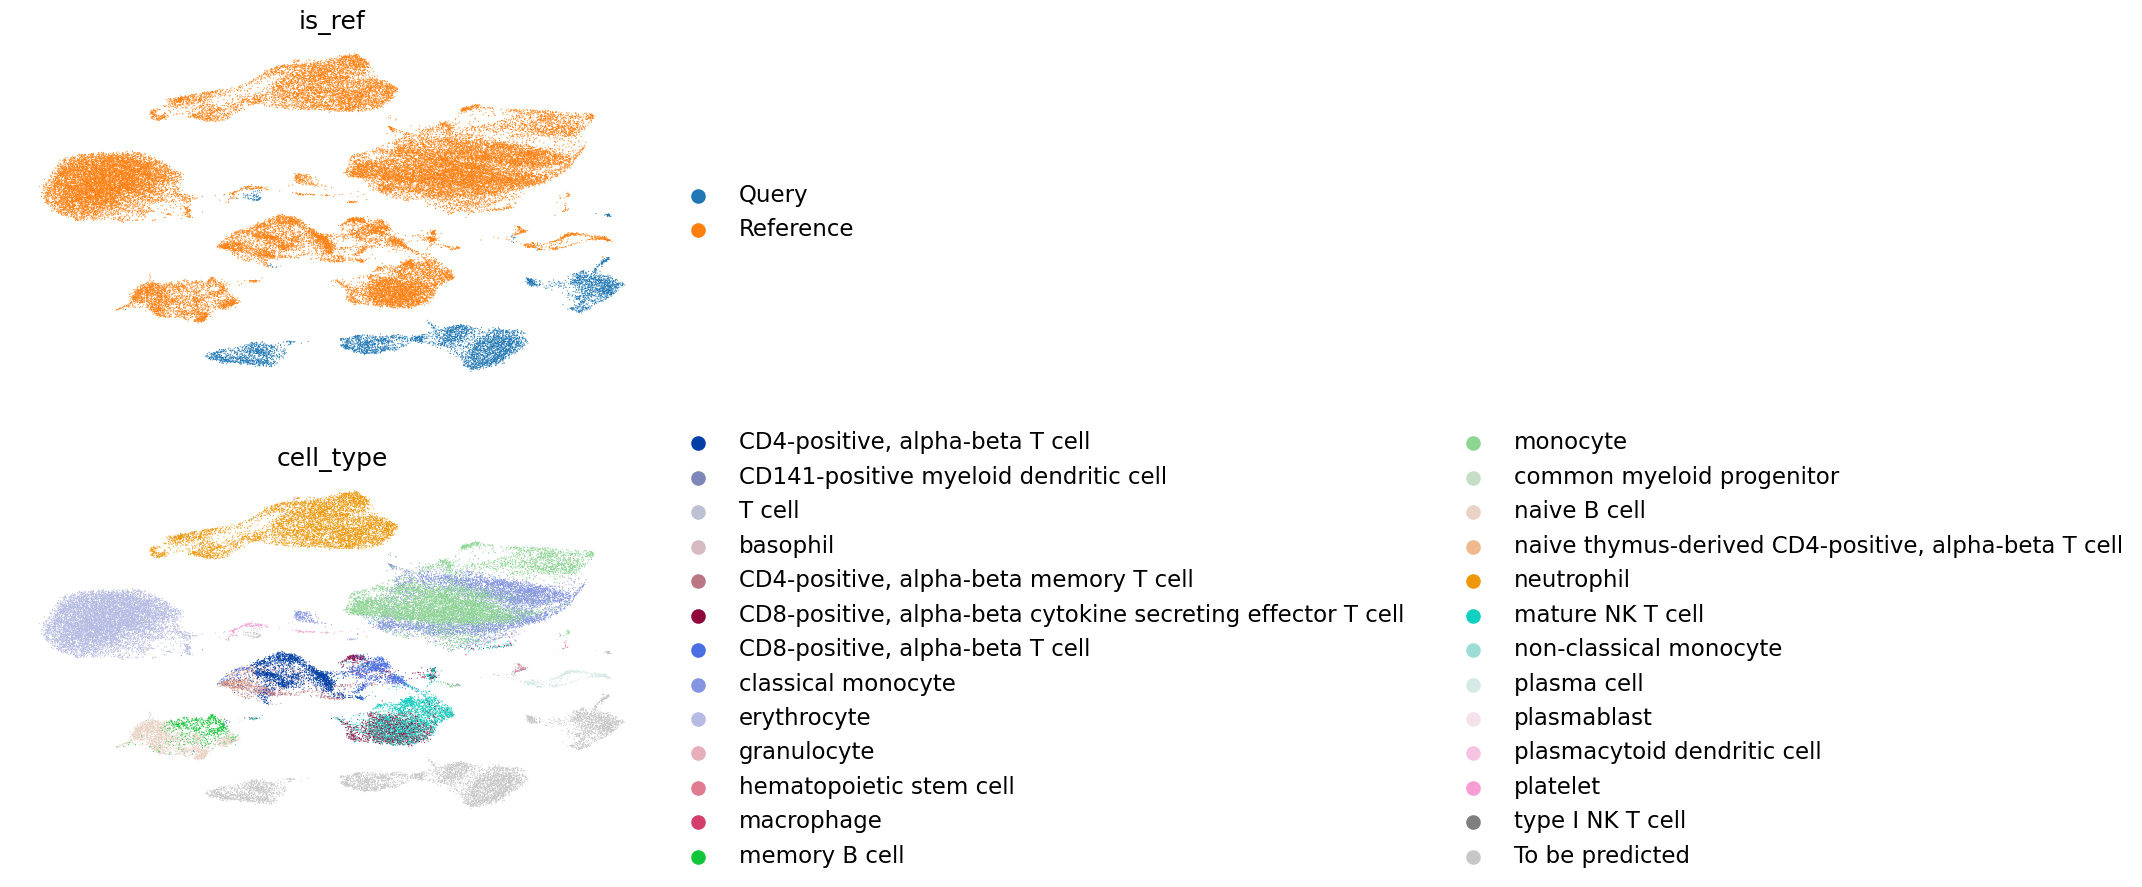

In [9]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(
    adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

## Reference mapping and transfer the annotations

We run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

In [10]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [14]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_emebd = test_embed_adata.obsm["X_scGPT"]

k = 10  # number of neighbotest_adatars


index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = test_adata.obs["seurat_clusters"].to_numpy()

In [28]:
test_embed_adata.obs["cell_type"] = preds

/home/jvfcavalcante/.conda/envs/scgpt/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


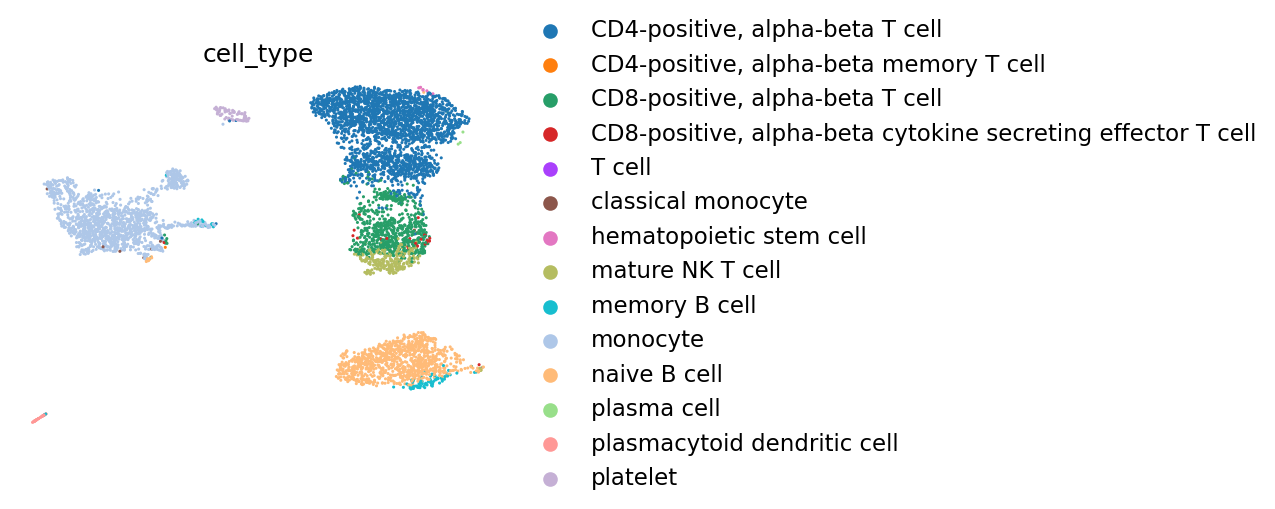

In [30]:
sc.pp.neighbors(test_embed_adata, use_rep="X_scGPT")
sc.tl.umap(test_embed_adata)
sc.pl.umap(
    test_embed_adata, color=cell_type_key, wspace=0.4, frameon=False, ncols=1
)